# CNN Model for UNO Card Detection

For the creation of the CNN model from scratch, we will be using the following modules:
1. Tensorflow: The main framework for the creation of the model
2. Matplotlib: For Analysis of the model

*~Done By Mikaia, Akilesh and Vaibhav~*

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    Flatten,
    Dense,
    Dropout,
    Rescaling,
    RandomRotation,
    RandomZoom,
    RandomBrightness,
    RandomContrast,
)
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt

In [ ]:
# Define the file directory of the dataset
data_dir = 'Uno Dataset 2'

In [ ]:
# Define the parameter of the input 
batch_size = 1
img_height = 224
img_width = 224
epochs=10

In [ ]:
# Make use of the tf.keras.utils.image_dataset_from_directory to load the dataset folder and obtain the class names
full_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  shuffle=True,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9625 files belonging to 54 classes.


In [5]:
# Calculate dataset size and split
dataset_size = full_ds.cardinality().numpy()
train_size = int(0.7 * dataset_size) 
val_size = int(0.15 * dataset_size)  
test_size = dataset_size - train_size - val_size

In [ ]:
# Split into train (70%), validation (15%), and test (15%) sets
train_ds = full_ds.take(train_size)
val_ds = full_ds.skip(train_size).take(val_size)
test_ds = full_ds.skip(train_size + val_size)

In [ ]:
# Print the class names extracted by keras
class_names = full_ds.class_names
class_names

['blue_0',
 'blue_1',
 'blue_2',
 'blue_3',
 'blue_4',
 'blue_5',
 'blue_6',
 'blue_7',
 'blue_8',
 'blue_9',
 'blue_draw_2',
 'blue_reverse',
 'blue_skip',
 'green_0',
 'green_1',
 'green_2',
 'green_3',
 'green_4',
 'green_5',
 'green_6',
 'green_7',
 'green_8',
 'green_9',
 'green_draw_2',
 'green_reverse',
 'green_skip',
 'red_0',
 'red_1',
 'red_2',
 'red_3',
 'red_4',
 'red_5',
 'red_6',
 'red_7',
 'red_8',
 'red_9',
 'red_draw_2',
 'red_reverse',
 'red_skip',
 'wild_change_colour',
 'wild_draw_four',
 'yellow_0',
 'yellow_1',
 'yellow_2',
 'yellow_3',
 'yellow_4',
 'yellow_5',
 'yellow_6',
 'yellow_7',
 'yellow_8',
 'yellow_9',
 'yellow_draw_2',
 'yellow_reverse',
 'yellow_skip']

In [ ]:
# Create a normalization layer to standardize the input from 0 to 255 to 0 to 1
# Apply the normalization layer to all the dataset (train, validation, and test)
normalization_layer = Rescaling(1./255)
normalized_ds = train_ds.map (lambda x,y : (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x,y : (normalization_layer(x), y))
normalized_test_ds = test_ds.map(lambda x,y : (normalization_layer(x), y))

In [ ]:
# Create and Define a simple data augmentation pipeline
# !NOTE: The parameter are to be adjusted slowly to avoid overfitting
data_augmentation = tf.keras.Sequential([
    RandomRotation(0.05),
    RandomBrightness(0.05),
    RandomZoom(0.0,0.1),
    RandomContrast(0.05)
])

In [ ]:
# Apply the data augmentation to the normalised training dataset
augmented_train_dataset = normalized_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

In [ ]:
# Combine both the normalized and augmented dataset
combined_train_dataset = normalized_ds.concatenate(augmented_train_dataset)

## Model Details
---

**The Model Contains 4 Categories of Layes**:
1. Input Layer
2. Features Extraction Layer
3. Classification Layer (denoted as X)
4. Output Layer

### Input Layer:
- The Input Layer takes image size of 224x224 pixels, RGB coloured.

### Features Extraction Layer:
- It consist of 8, 2D Convolutional Layer *with ReLU* (Rectified Linear Unit) Activation Function
- The *First 4 Convolutional Layers* are with a padding of "valid" which remove the padding.
- The Next Convolutional Layers are with a padding of "same" so that the corner are included when performing the Pooling
- Each Convolutional Layer, is followed by *MaxPooling Layer*, exept the last one which is followed by an *Average Pooling Layer*.
- The Pooling Layers have *a sliding window of 2x2* and *a default strides of 1x1*.
- The Convolutional Layers Filter's Configuration is as follow: *32,32,64,64,128,256,512,512.*

### Classification Layer:
- This Layer start with average pooling layer, to reduce the spatial dimension and converts features map into a single vector.
- It contains 2 Dense layer with 1024 units followed by a dropout layer with a 0.2 rate of regularization.

### Output Layer:
- This layer consist of a singular Dense layer with *54 units* and *SIGMOID* activation function.


---

**Compilation**

- The model was compiled with the following parameter:
    1. Adam with a initial learning rate of 0.0001 as Optimizer
    2. Sparse Catergorical Cross Entropy as loss function, which performs best for multi class classification.
    3. A singular metric which is accuracy

  

In [ ]:
# Build The Model
input_shape = (224, 224, 3)
inputs = Input(shape=input_shape)

features_extraction = Conv2D(32, 3, padding="valid", activation="relu")(inputs)
features_extraction = MaxPooling2D((2, 2))(features_extraction)
features_extraction = Conv2D(32, 3, padding="valid", activation="relu")(features_extraction)
features_extraction = MaxPooling2D((2, 2))(features_extraction)
features_extraction = Conv2D(64, 3, padding="valid", activation="relu")(features_extraction)
features_extraction = MaxPooling2D((2, 2))(features_extraction)
features_extraction = Conv2D(64, 3, padding="valid", activation="relu")(features_extraction)
features_extraction = MaxPooling2D((2, 2))(features_extraction)
features_extraction = Conv2D(128, 3, padding="same", activation="relu")(features_extraction)
features_extraction = MaxPooling2D((2, 2))(features_extraction)
features_extraction = Conv2D(256, 3, padding="same", activation="relu")(features_extraction)
features_extraction = MaxPooling2D((2, 2))(features_extraction)
features_extraction = Conv2D(512, 3, padding="same", activation="relu")(features_extraction)
features_extraction = MaxPooling2D((2, 2))(features_extraction)
features_extraction = Conv2D(512, 3, padding="same", activation="relu")(features_extraction)



x = GlobalAveragePooling2D()(features_extraction)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(54, activation='sigmoid', name='value_output')(x)


model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

# Display the model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 3, 3, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ value_output (Dense)            │ (None, 54)             │        55,350 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,245,014 (12.38 MB)

 Trainable params: 3,245,014 (12.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Obtain the buffer size of the combined train dataset
buffer_size = combined_train_dataset.cardinality().numpy()

# Shuffle the combined train dataset
shuffled_train_dataset = combined_train_dataset.shuffle(buffer_size=buffer_size, reshuffle_each_iteration=True)

In [ ]:
# Train the model
history = model.fit(
    shuffled_train_dataset,
    validation_data=normalized_val_ds,
    epochs=epochs
)

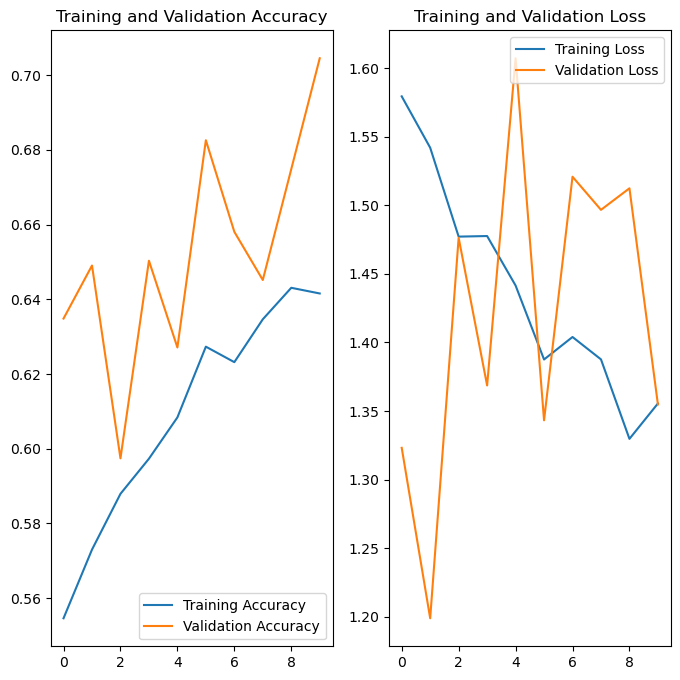

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model2.save("model_93.keras")

In [40]:
model.save('model1.h5')

*Train An Already Existing Model*:

The code below will load and allow the already saved to be improved further with newer dataset.



In [ ]:
# Import load_model function from keras.models
# Load the model
from tensorflow.keras.models import load_model

trained_model = load_model("model_90.2.keras")

In [ ]:
# Compile the model with the same parameters as before
trained_model.compile(
    optimizer=Adam(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)


In [ ]:
# Train the model and save the history for further analysis
# The Epoch should be varied based on the accuracy of the model being loaded
trained_history = trained_model.fit(
    shuffled_train_dataset,
    validation_data=normalized_val_ds,
    shuffle=True,
    epochs=15, # 
)

Epoch 1/15


/Users/midev/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-11-06 23:38:58.027923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2183 of 13474
2024-11-06 23:39:08.048191: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 4379 of 13474
2024-11-06 23:39:18.104888: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 6554 of 13474
2024-11-06 23:39:38.031570: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 10

    4/13474 ━━━━━━━━━━━━━━━━━━━━ 4:52 22ms/step - accuracy: 0.5833 - loss: 1.5308    

2024-11-06 23:39:52.720623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13474/13474 ━━━━━━━━━━━━━━━━━━━━ 413s 26ms/step - accuracy: 0.6024 - loss: 1.5284 - val_accuracy: 0.8974 - val_loss: 0.3801
Epoch 2/15


2024-11-06 23:45:49.794254: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2172 of 13474
2024-11-06 23:46:09.857493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 6535 of 13474
2024-11-06 23:46:29.791493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 10445 of 13474


    4/13474 ━━━━━━━━━━━━━━━━━━━━ 5:09 23ms/step - accuracy: 0.7917 - loss: 0.8927    

2024-11-06 23:46:45.291909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13474/13474 ━━━━━━━━━━━━━━━━━━━━ 416s 26ms/step - accuracy: 0.6351 - loss: 1.4119 - val_accuracy: 0.9106 - val_loss: 0.5820
Epoch 3/15


2024-11-06 23:52:45.940690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2170 of 13474
2024-11-06 23:52:55.979852: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 4371 of 13474
2024-11-06 23:53:15.937643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 8467 of 13474
2024-11-06 23:53:35.938334: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 12549 of 13474


    7/13474 ━━━━━━━━━━━━━━━━━━━━ 5:17 24ms/step - accuracy: 0.8915 - loss: 0.2141   

2024-11-06 23:53:40.531127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13474/13474 ━━━━━━━━━━━━━━━━━━━━ 420s 26ms/step - accuracy: 0.6458 - loss: 1.3712 - val_accuracy: 0.9120 - val_loss: 0.5188
Epoch 4/15


2024-11-06 23:59:45.983446: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2178 of 13474
2024-11-07 00:00:05.984130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 6097 of 13474
2024-11-07 00:00:25.974525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 9724 of 13474
2024-11-07 00:00:36.009965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 11408 of 13474


    3/13474 ━━━━━━━━━━━━━━━━━━━━ 5:54 26ms/step - accuracy: 1.0000 - loss: 0.0978        

2024-11-07 00:00:47.429490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13474/13474 ━━━━━━━━━━━━━━━━━━━━ 431s 27ms/step - accuracy: 0.6804 - loss: 1.2426 - val_accuracy: 0.9265 - val_loss: 0.6858
Epoch 5/15


2024-11-07 00:06:56.648312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2141 of 13474
2024-11-07 00:07:06.662829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 4190 of 13474
2024-11-07 00:07:26.639298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 8053 of 13474
2024-11-07 00:07:36.642284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 9936 of 13474


    1/13474 ━━━━━━━━━━━━━━━━━━━━ 259:50:59 69s/step - accuracy: 0.0000e+00 - loss: 3.4411

2024-11-07 00:07:55.935547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13474/13474 ━━━━━━━━━━━━━━━━━━━━ 433s 27ms/step - accuracy: 0.6883 - loss: 1.2602 - val_accuracy: 0.9265 - val_loss: 0.4808
Epoch 6/15


2024-11-07 00:14:10.103770: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2120 of 13474
2024-11-07 00:14:20.122370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 4274 of 13474
2024-11-07 00:14:40.097696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 8065 of 13474
2024-11-07 00:14:50.099737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 9995 of 13474


    4/13474 ━━━━━━━━━━━━━━━━━━━━ 4:53 22ms/step - accuracy: 1.0000 - loss: 0.0037        

2024-11-07 00:15:08.178557: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13474/13474 ━━━━━━━━━━━━━━━━━━━━ 424s 26ms/step - accuracy: 0.6886 - loss: 1.2492 - val_accuracy: 0.9453 - val_loss: 0.4671
Epoch 7/15


2024-11-07 00:21:13.989667: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2119 of 13474
2024-11-07 00:21:34.011798: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 6298 of 13474
2024-11-07 00:21:53.984694: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 10007 of 13474
2024-11-07 00:22:03.988030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 11888 of 13474


    3/13474 ━━━━━━━━━━━━━━━━━━━━ 5:57 27ms/step - accuracy: 0.7222 - loss: 1.0284        

2024-11-07 00:22:12.255590: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13474/13474 ━━━━━━━━━━━━━━━━━━━━ 423s 26ms/step - accuracy: 0.6911 - loss: 1.2408 - val_accuracy: 0.9279 - val_loss: 0.4634
Epoch 8/15


2024-11-07 00:28:16.931791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 1930 of 13474
2024-11-07 00:28:36.905322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 6110 of 13474
2024-11-07 00:28:46.905403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 8044 of 13474
2024-11-07 00:28:56.907129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 9982 of 13474


    3/13474 ━━━━━━━━━━━━━━━━━━━━ 6:54 31ms/step - accuracy: 1.0000 - loss: 0.1855        

2024-11-07 00:29:14.479886: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13474/13474 ━━━━━━━━━━━━━━━━━━━━ 415s 26ms/step - accuracy: 0.6900 - loss: 1.2424 - val_accuracy: 0.9252 - val_loss: 0.4729
Epoch 9/15


2024-11-07 00:35:11.638861: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2172 of 13474
2024-11-07 00:35:21.685310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 4377 of 13474
2024-11-07 00:35:41.632153: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 8361 of 13474
2024-11-07 00:36:01.627412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 12337 of 13474


    4/13474 ━━━━━━━━━━━━━━━━━━━━ 5:00 22ms/step - accuracy: 0.8542 - loss: 0.8079    

2024-11-07 00:36:07.338909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13474/13474 ━━━━━━━━━━━━━━━━━━━━ 420s 26ms/step - accuracy: 0.7122 - loss: 1.1754 - val_accuracy: 0.9335 - val_loss: 1.1548
Epoch 10/15


2024-11-07 00:42:11.698810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2138 of 13474
2024-11-07 00:42:31.707135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 6410 of 13474
2024-11-07 00:42:51.700052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 10249 of 13474


    4/13474 ━━━━━━━━━━━━━━━━━━━━ 5:18 24ms/step - accuracy: 1.0000 - loss: 0.2981    

2024-11-07 00:43:08.451931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13474/13474 ━━━━━━━━━━━━━━━━━━━━ 406s 25ms/step - accuracy: 0.6936 - loss: 1.2409 - val_accuracy: 0.9466 - val_loss: 0.3410
Epoch 11/15


2024-11-07 00:48:57.199519: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2207 of 13474
2024-11-07 00:49:07.220480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 4491 of 13474
2024-11-07 00:49:27.196191: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 8331 of 13474
2024-11-07 00:49:37.198822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 10272 of 13474


    3/13474 ━━━━━━━━━━━━━━━━━━━━ 6:04 27ms/step - accuracy: 0.7222 - loss: 0.8877        

2024-11-07 00:49:53.717628: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13474/13474 ━━━━━━━━━━━━━━━━━━━━ 418s 26ms/step - accuracy: 0.7121 - loss: 1.1600 - val_accuracy: 0.9376 - val_loss: 0.8578
Epoch 12/15


2024-11-07 00:55:54.791135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2202 of 13474
2024-11-07 00:56:04.802939: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 4453 of 13474
2024-11-07 00:56:24.774236: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 8616 of 13474
2024-11-07 00:56:34.774379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 10612 of 13474
2024-11-07 00:56:44.779129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 12591 of 13474


    3/13474 ━━━━━━━━━━━━━━━━━━━━ 5:57 27ms/step - accuracy: 1.0000 - loss: 1.0855e-05    

2024-11-07 00:56:49.229616: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13474/13474 ━━━━━━━━━━━━━━━━━━━━ 413s 26ms/step - accuracy: 0.6999 - loss: 1.2378 - val_accuracy: 0.9577 - val_loss: 0.1791
Epoch 13/15


2024-11-07 01:02:47.987488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2100 of 13474
2024-11-07 01:03:07.962200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 6408 of 13474
2024-11-07 01:03:27.937533: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 10131 of 13474
2024-11-07 01:03:37.941611: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 11914 of 13474


    1/13474 ━━━━━━━━━━━━━━━━━━━━ 256:17:59 68s/step - accuracy: 1.0000 - loss: 0.3157

2024-11-07 01:03:46.247923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13474/13474 ━━━━━━━━━━━━━━━━━━━━ 422s 26ms/step - accuracy: 0.7162 - loss: 1.1660 - val_accuracy: 0.9487 - val_loss: 0.4529
Epoch 14/15


2024-11-07 01:09:50.125960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2103 of 13474
2024-11-07 01:10:00.138797: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 4102 of 13474
2024-11-07 01:10:10.172971: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 6207 of 13474
2024-11-07 01:10:30.131578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 9820 of 13474


    3/13474 ━━━━━━━━━━━━━━━━━━━━ 6:21 28ms/step - accuracy: 0.2778 - loss: 2.7996        

2024-11-07 01:10:48.708148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13474/13474 ━━━━━━━━━━━━━━━━━━━━ 418s 26ms/step - accuracy: 0.7145 - loss: 1.1927 - val_accuracy: 0.9189 - val_loss: 0.3861
Epoch 15/15


2024-11-07 01:16:48.538122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2068 of 13474
2024-11-07 01:16:58.558791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 4221 of 13474
2024-11-07 01:17:18.535154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 8284 of 13474
2024-11-07 01:17:28.546165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 10338 of 13474


In [ ]:
# Test the model with test dataset and outputing the accuracy
_, test_accuracy = trained_model.evaluate(normalized_test_ds)
test_accuracy

958/958 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - accuracy: 0.8930 - loss: 0.4844


0.9018788933753967

In [ ]:
# Save the model with the following name format: model_{test_accuracy}.keras
trained_model.save(f"model_{test_accuracy*100:.1f}.keras")